In [65]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
import warnings
warnings.filterwarnings('ignore')
# ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sample_data

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

# Load Data

In [66]:
# Load Data
df = pd.read_csv('organics.csv')

# Preview data
df.info()
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22223 entries, 0 to 22222
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               22223 non-null  int64  
 1   DemAffl          21138 non-null  float64
 2   DemAge           20715 non-null  float64
 3   DemCluster       21549 non-null  float64
 4   DemClusterGroup  21549 non-null  object 
 5   DemGender        19711 non-null  object 
 6   DemReg           21758 non-null  object 
 7   DemTVReg         21758 non-null  object 
 8   PromClass        22223 non-null  object 
 9   PromSpend        22223 non-null  float64
 10  PromTime         21942 non-null  float64
 11  TargetBuy        22223 non-null  int64  
 12  TargetAmt        22223 non-null  int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 2.2+ MB
     ID  DemAffl  DemAge  DemCluster DemClusterGroup DemGender    DemReg  \
0   140     10.0    76.0        16.0               C         U 

# Deal with Missing Values

In [67]:
# Check for Nulls
missing_value_counts = df.isna().sum()
missing_value_percentages = missing_value_counts/len(df) * 100
print(missing_value_percentages)


ID                  0.000000
DemAffl             4.882329
DemAge              6.785762
DemCluster          3.032894
DemClusterGroup     3.032894
DemGender          11.303604
DemReg              2.092427
DemTVReg            2.092427
PromClass           0.000000
PromSpend           0.000000
PromTime            1.264456
TargetBuy           0.000000
TargetAmt           0.000000
dtype: float64


In [68]:
# Deal with Nulls in DemGender
unique = df['DemGender'].unique()
unique

# Fill missing values with U for unknown
df_clean = df
df_clean['DemGender'].fillna('U', inplace=True)

# Check if it worked
unique = df_clean['DemGender'].unique()
unique

array(['U', 'F', 'M'], dtype=object)

In [69]:
# Since the rest of the results have less than 10% nulls, I am going to drop them
df_clean = df_clean.dropna()

# Check for Nulls again
missing_value_counts = df_clean.isna().sum()
missing_value_percentages = missing_value_counts/len(df) * 100
print(missing_value_percentages)

ID                 0.0
DemAffl            0.0
DemAge             0.0
DemCluster         0.0
DemClusterGroup    0.0
DemGender          0.0
DemReg             0.0
DemTVReg           0.0
PromClass          0.0
PromSpend          0.0
PromTime           0.0
TargetBuy          0.0
TargetAmt          0.0
dtype: float64


In [70]:
# check for duplicates
duplicates = df_clean.duplicated()
# get the count of duplicate records
duplicates.sum()

0

# Initial Insights

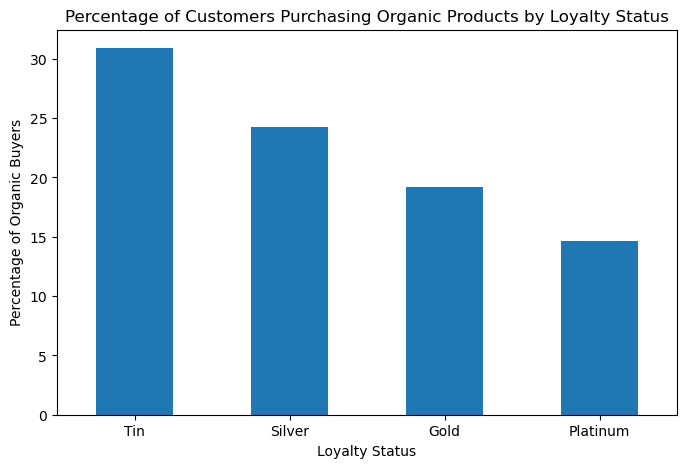

In [71]:
# Define custom order
order = ['Tin', 'Silver', 'Gold', 'Platinum']
df_clean['PromClass'] = pd.Categorical(df_clean['PromClass'], categories=order, ordered=True)

# Calculate purchase rates by loyalty status
organic_purchase_rates = df_clean.groupby('PromClass')['TargetBuy'].mean() * 100

# Plot the results
organic_purchase_rates.plot(kind='bar', figsize=(8,5))
plt.title("Percentage of Customers Purchasing Organic Products by Loyalty Status")
plt.xlabel("Loyalty Status")
plt.ylabel("Percentage of Organic Buyers")
plt.xticks(rotation=0)
plt.show()

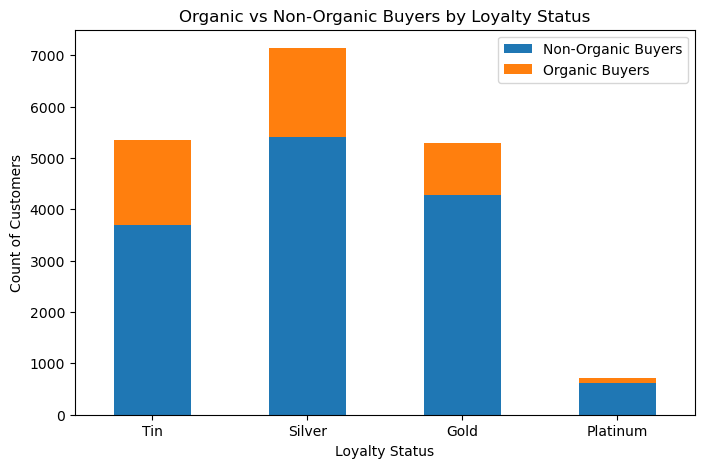

In [72]:
# Define custom order
order = ['Tin', 'Silver', 'Gold', 'Platinum']
df_clean['PromClass'] = pd.Categorical(df_clean['PromClass'], categories=order, ordered=True)

# Count organic buyers across loyalty groups
loyalty_vs_target = df_clean.groupby(['PromClass', 'TargetBuy']).size().unstack()

# Plot grouped bar chart
loyalty_vs_target.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title("Organic vs Non-Organic Buyers by Loyalty Status")
plt.xlabel("Loyalty Status")
plt.ylabel("Count of Customers")
plt.xticks(rotation=0)
plt.legend(["Non-Organic Buyers", "Organic Buyers"], loc='upper right')
plt.show()

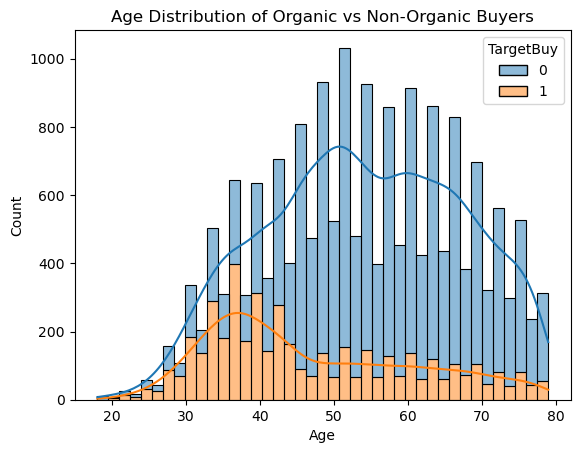

In [73]:
sns.histplot(data=df_clean, x='DemAge', hue='TargetBuy', multiple='stack', kde=True)
plt.title("Age Distribution of Organic vs Non-Organic Buyers")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

# Preprocess Data

In [74]:
# Convert response from an integer to a categorical variable
df_clean['TargetBuy'] = df_clean['TargetBuy'].astype('category')

df_num = df_clean[['ID', 'DemAffl', 'DemAge', 'DemCluster', 'PromSpend', 'PromTime', 'TargetBuy', 'TargetAmt']]
# Compute correlation matrix to prevent multicollinearity
correlation_matrix = df_num.corr()
print(correlation_matrix)

#Drop TargetAmt because its highly corrolated at 0.913721 and ID because we dont need it
df_clean.drop(['TargetAmt'], axis=1, inplace=True)
df_clean.drop(['ID'], axis=1, inplace=True)

                  ID   DemAffl    DemAge  DemCluster  PromSpend  PromTime  \
ID          1.000000  0.002442  0.007787   -0.015306   0.005387  0.000472   
DemAffl     0.002442  1.000000 -0.136239    0.030829  -0.024680 -0.030445   
DemAge      0.007787 -0.136239  1.000000   -0.171854   0.268218  0.210319   
DemCluster -0.015306  0.030829 -0.171854    1.000000  -0.106672 -0.054385   
PromSpend   0.005387 -0.024680  0.268218   -0.106672   1.000000  0.035769   
PromTime    0.000472 -0.030445  0.210319   -0.054385   0.035769  1.000000   
TargetBuy   0.004725  0.363643 -0.299714    0.064641  -0.080367 -0.053670   
TargetAmt   0.006015  0.466101 -0.305704    0.065224  -0.082629 -0.053458   

            TargetBuy  TargetAmt  
ID           0.004725   0.006015  
DemAffl      0.363643   0.466101  
DemAge      -0.299714  -0.305704  
DemCluster   0.064641   0.065224  
PromSpend   -0.080367  -0.082629  
PromTime    -0.053670  -0.053458  
TargetBuy    1.000000   0.913721  
TargetAmt    0.913721   1.

# Split into Train and Test Data

In [79]:
# Fit full logistic regression model to examine the significance of the terms
X = df_clean.drop(['TargetBuy'], axis=1)
X = pd.get_dummies(X, columns=['PromClass', 'DemClusterGroup', 'DemGender', 'DemReg', 'DemTVReg'], drop_first=True, dtype='float')

y = df_clean['TargetBuy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.info()
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12957 entries, 9973 to 18960
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DemAffl                12957 non-null  float64
 1   DemAge                 12957 non-null  float64
 2   DemCluster             12957 non-null  float64
 3   PromSpend              12957 non-null  float64
 4   PromTime               12957 non-null  float64
 5   PromClass_Silver       12957 non-null  float64
 6   PromClass_Gold         12957 non-null  float64
 7   PromClass_Platinum     12957 non-null  float64
 8   DemClusterGroup_B      12957 non-null  float64
 9   DemClusterGroup_C      12957 non-null  float64
 10  DemClusterGroup_D      12957 non-null  float64
 11  DemClusterGroup_E      12957 non-null  float64
 12  DemClusterGroup_F      12957 non-null  float64
 13  DemClusterGroup_U      12957 non-null  float64
 14  DemGender_M            12957 non-null  float64
 15  DemG

# Decision Tree

In [80]:
# create an instance of a decision tree classifier using default values
dt = DecisionTreeClassifier(max_depth = 25, min_samples_leaf=10, ccp_alpha = 0.001)

# fit the model to the training data
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.001, max_depth=25, min_samples_leaf=10)